# Trajectory Optimization

## Notebook Setup

### Julia Setup

In [2]:
using LaTeXStrings
using Plots
using Polynomials
import Base: ctranspose

# The Poly class has an odd quirk in that is defines the conjugate transpose
# operator A' as differentiation of the polynomial. While this makes some 
# sense for an isolated polynomial objects, for arrays it has unexpected 
# behavior: [p q]' == [polyder(p), polyder(q)']. In this notebook, I will be
# manipulating vectors and matrices of polynomial objects; I do not want these
# objects to be differentiated when transposed. Therefore, I'm redefining the
# ctranspose operator to simply return the original polynomial object.
ctranspose{T}(p::Poly{T}) = p

# The line selects which plotting backend will be used to generate the plots
# shown in this notebook.
pyplot();

# The function below allows quick printing of arrays of rational numbers
function print_rational(title::String, data::Array{Rational{Int64},2})
    @printf("%s:\n", title)
    for i in 1:size(data,1)
        for j in 1:size(data,2)
            @printf("%4d/%-4d", data[i,j].num, data[i,j].den)
        end
        println()
    end
    println()
end

print_rational (generic function with 1 method)

### Latex Macros

- Vector Typeface: $ \newcommand{\vec}[1]{\boldsymbol{#1}} $
- Matrix Typeface: $ \newcommand{\mat}[1]{\boldsymbol{#1}} $

## Overview

The objective of this project is to develop a trajectory optimization tool that can be used to assess the maximum range of a Conventional Prompt Global Strike (CPGS) weapon system. CPGS weapon systems, have been a major research focus of the US Department of Defense for over a decade, with several development programs currently underway ([Ref. 1](https://fas.org/sgp/crs/nuke/R41464.pdf)). This project is specifically interested in CPGS systems that employ the “boost-glide” technique whereby a maneuverable glide vehicle is accelerated to hypersonic velocities using a multi-stage solid rocket booster.

## Trajectory Computation via Implicit CG Method

One of the key elements of the trajectory optimization problem is discretizing the equations of motion that define how the vehicle responds to the control input. This discretization can be accomplished in many ways, with modern state-of-the-art codes predominantly utilizing high-order
collocation methods. In this project we discretize the governing equations using an implicit Continuous Galerkin (CG) method in conjunction with quintic Hermite basis functions.

### Governing Differential Equations

The trajectory of a hypersonic boost-glide systems can be modeled using a pair of coupled second-order differential equations, similar to those shown below.

\begin{align}
    \label{eq:governing_x} \ddot{x} &= f^x(t, x, y, \dot{x}, \dot{y}, \alpha) \\
    \label{eq:governing_y} \ddot{y} &= f^y(t, x, y, \dot{x}, \dot{y}, \alpha)
\end{align}

| Variables   | Description
|:-----------:|-------------
| $x$,$y$     | Vehicle position relative to inertial space
| $f^x$,$f^y$ | Force acting on the vehicle (per unit mass)
| $\alpha$    | Vehicle Angle of attack (control variable)

Note that for the purposes of this study, we consider the angle of attack to be the control variable that allows us to shape the trajectory. In reality, the angle of attack is a consequence of how the vehicle thrust is vectored and/or how the aerodynamic control surfaces are deflected. However, modeling the how the vehicle attitude changes in response to control inputs is beyond the scope of what is necessary for this project. Instead, we simply assume that a control system exists and that it can trim the vehicle to follow the desired angle of attack profile. We can always place limits on the angle of attack profile if necessary during the optimization process.

### CG System of Equations

The CG discretization proceeds by converting the differential equations above into an equivalent weak form by multiplying each equation by an arbitrary “weighting” or “test” function, $w(t)$, and integrating. (Note: from here on out, we will only show the $x$-equation; the $y$-equation is handled in an identical fashion.)

\begin{align}
    \int_{t_0}^{t_f} w\ddot{x}~dt & = \int_{t_0}^{t_f} wf^x~dt \\
    w\dot{x}\big|_{t_0}^{t_f} - \int_{t_0}^{t_f} \dot{w}\dot{x}~dt & = \int_{t_0}^{t_f} wf^x~dt
\end{align}

Introducing the notation $(u,v)=\int_{t_0}^{t_f}uv~dt$ yields a concise statement of the governing equation in weak form:

\begin{equation}
    (\dot{w},\dot{x}) + (w,f^x) + w\dot{x}\big|_{t_0} - w\dot{x}\big|_{t_f} = 0
\end{equation}

At this point, it is necessary to select a method of parameterizing the unknown functions $x(t)$ and $w(t)$. For this application, we will utilize high-order (quintic) Hermite basis functions. The reason for selecting this basis set is as follows:

1. Since we can safely assume the vehicles acceleration history will be at least $C^0$ continuous, the vehicle position history will be at minimum $C^2$ continuous. Using quintic Hermite shape functions ensures that that the computed trajectory belongs to the space of $C^2$ continuous functions. (Note: high-jerk events like stage separation will be addressed by stitching together two separate CG discretizations using optimizer equality constraints).

2. Since Hermite shape functions utilize the nodal values of position, velocity, etc. as the shape function coefficients, implementing boundary conditions and trajectory constraints (altitude limits, terminal velocity requirements, etc.) is trivial.

3. Quintic Hermite interpolation is 6-th order accurate, which enables highly accurate trajectory solutions with small degrees of freedom counts.

Let $t_i,~i = 1,...,N$ be a series of ordered points spanning the interval $[t_0, t_f]$; the points need not uniformly spaced. The vector-valued function $\vec{\phi}_i(t)$ represents the Hermite basis functions associated with the $i$-th node. The vector $\vec{x}_i$ represents the coefficients used to scale the basis
functions for that node. In the case of quintic Hermite basis functions, these coefficients are simply the value of the solution function and its first two derivatives at the $i$-th node:

\begin{equation}
    \vec{x}_i = \left[ x(t_i), \dot{x}(t_i), \ddot{x}(t_i) \right]^T
\end{equation}

The function $x(t)$ is then constructed via a linear super-position of the coefficient-weighted basis functions for all nodes, as shown below. The Galerkin test function, $w(t)$, is parameterized similarly.

\begin{align}
    x(t) &= \sum_{i=1}^{N} \vec{\phi}_i^T(t)\cdot \vec{x}_i \\
    w(t) &= \sum_{i=1}^{N} \vec{\phi}_i^T(t)\cdot \vec{w}_i
\end{align}

We then substitute these parameterizations into the weak form of the governing equation. For brevity, I will drop the explicit summation symbols; summation is implied by products with repeated indices.

\begin{equation}
    \left( \vec{\dot\phi}_i^T\vec{w}_i, \vec{\dot\phi}_j^T\vec{w}_j \right) +
    \left( \vec{\phi}_i^T\vec{w}_i, f^x \right) + 
    \left( \vec{\phi}_i^T(t_0)\vec{w}_i \right) \cdot \left( \vec{\dot\phi}_j^T(t_0)\vec{x}_j \right) -
    \left( \vec{\phi}_i^T(t_f)\vec{w}_i \right) \cdot \left( \vec{\dot\phi}_j^T(t_f)\vec{x}_j \right) =
    0   
\end{equation}

Note that since $\vec{\phi}_i^T\vec{w}_i = \vec{w}_i^T\vec{\phi}_i$, we can rewrite the above equation and factor out parameterization constants for the basis functions as shown below:

\begin{equation}
    \vec{w}_i^T \left[
        \left[
           \left( \vec{\dot\phi}_i, \vec{\dot\phi}^T_j \right) + 
           \left. \vec{\phi}_i\vec{\dot\phi}_j^T \right|_{t_0} -
           \left. \vec{\phi}_i\vec{\dot\phi}_j^T \right|_{t_f}
        \right] \vec{x}_j +
        \left( \vec{\phi}_i, f^x \right)
    \right] = 0
\end{equation}

Since the weighting function is arbitrary, the values of the $\vec{w}_i$’s are free parameters. Thus, the only way for the above equation to be uniformly zero for any possible value of the $\vec{w}_i$’s is for the bracketed expression itself to be zero for every value of $i = 1,...,N$. The result is a system of simultaneous, non-linear equations that must be solved for the unknown values of the $\vec{x}_j$’s:

\begin{equation}
    \label{eq:cg_system_of_equations}
    \left[
        \left( \vec{\dot\phi}_i, \vec{\dot\phi}^T_j \right) +
        \left. \vec{\phi}_i\vec{\dot\phi}_j^T \right|_{t_0} -
        \left. \vec{\phi}_i\vec{\dot\phi}_j^T \right|_{t_f}
    \right] \vec{x}_j +
    \left( \vec{\phi}_i, f^x \right) =
    0, ~~~~
    \forall i = 1,...,N
\end{equation}


### Quintic Hermite Shape Functions

Hermite shape functions enable construction of a continuous interpolant on the interval $\tau \in [0,1]$ given the value of a function and its derivatives at the endpoints of the interval. The canonical form of the quintic (5th order) Hermite shape function are:

\begin{align}
    H_0^5(\tau) &= 1 - 10\tau^3 + 15\tau^4 - 6\tau^5 \\
    H_1^5(\tau) &= \tau - 6\tau^3 + 8\tau^4 - 3\tau^5 \\
    H_2^5(\tau) &= \frac{1}{2}\left( \tau^2 - 3\tau^3 + 3\tau^4 - \tau^5 \right) \\
    H_3^5(\tau) &= 10\tau^3 - 15\tau^4 + 6\tau^5 \\ 
    H_4^5(\tau) &= -4\tau^3 + 7\tau^4 -3\tau^5 \\
    H_5^5(\tau) &= \frac{1}{2}\left( \tau^3 - 2\tau^4 + \tau^5 \right)
\end{align}

(Polynomials.Poly{#T<:Any}) in module Polynomials at C:\Users\Jeff\.julia\v0.5\Polynomials\src\Polynomials.jl:440 overwritten in module Main at In[2]:13.



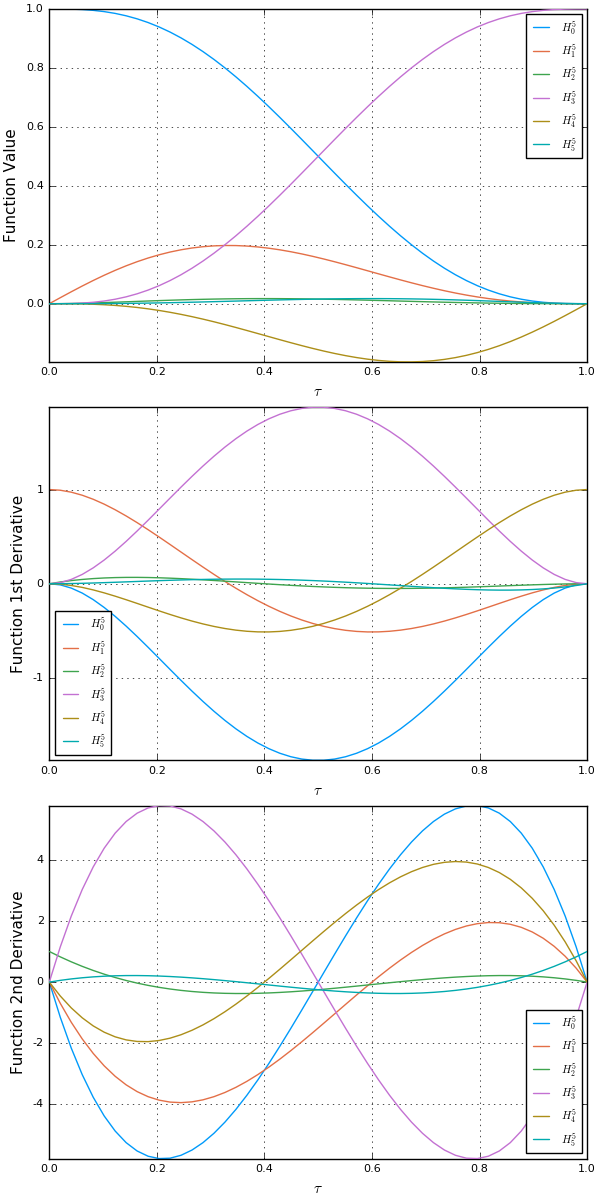

In [3]:
# Define and plot quintic Hermite shape functions

H = [
    Poly([ 1,   0,   0, -10,  15,  -6 ]//1, :τ)
    Poly([ 0,   1,   0,  -6,   8,  -3 ]//1, :τ)
    Poly([ 0,   0,   1,  -3,   3,  -1 ]//2, :τ)
    Poly([ 0,   0,   0,  10, -15,   6 ]//1, :τ)
    Poly([ 0,   0,   0,  -4,   7,  -3 ]//1, :τ)
    Poly([ 0,   0,   0,   1,  -2,   1 ]//2, :τ)
]

τ  = linspace(0,1)
H1 = polyder.(H)
H2 = polyder.(H1)

plot(
    plot(τ, polyval.(H',τ),  ylabel="Function Value"),
    plot(τ, polyval.(H1',τ), ylabel="Function 1st Derivative"),
    plot(τ, polyval.(H2',τ), ylabel="Function 2nd Derivative"),
    label=["\$H^5_$i\$" for i in (0:5)'],
    xlabel=L"\tau",
    layout=(3,1),
    size=(600,1200),
)
    

The interpolant is constructed from the shape functions as follows:

\begin{equation}
\begin{split}
    x(\tau) &= H_0^5(\tau)\cdot x\bigg|_{\tau=0} 
             + H_1^5(\tau)\cdot \frac{dx}{d\tau}\bigg|_{\tau=0} 
             + H_2^5(\tau)\cdot \frac{d^2x}{d\tau^2}\bigg|_{\tau=0} \\
            &+ H_3^5(\tau)\cdot x\bigg|_{\tau=1}
             + H_4^5(\tau)\cdot \frac{dx}{d\tau}\bigg|_{\tau=1} 
             + H_5^5(\tau)\cdot \frac{d^2x}{d\tau^2}\bigg|_{\tau=1}
\end{split}
\end{equation}

Three of the shape functions are associated with the degrees of freedom on the left end of the interval while the other three are assoicated with the right end of the interval. Therefore, let’s define

\begin{align}
    \vec{h}_L(\tau) &= [H_0^5(\tau), H_1^5(\tau), H_2^5(\tau)]^T \\
    \vec{h}_R(\tau) &= [H_3^5(\tau), H_4^5(\tau), H_5^5(\tau)]^T \\
\end{align}

This allows us to write the interpolant as

\begin{equation}
    x(\tau) = 
        \vec{h}_L^T\cdot\left[ 
            \begin{array}{c} 
                x \\
                \frac{dx}{d\tau} \\
                \frac{d^2x}{d\tau^2} \\
            \end{array}
        \right]_{\tau=0}
        + 
        \vec{h}_R^T\cdot\left[ 
            \begin{array}{c} 
                x \\
                \frac{dx}{d\tau} \\
                \frac{d^2x}{d\tau^2} \\
            \end{array}
        \right]_{\tau=1}
\end{equation}

Notice that the derivatives required for this interpolant are with respect to $\tau$, the interval-local coordinate. We previously defined the $\vec{x}_i$’s as specifying the true time derivatives, so a scaling must be applied. (Note: given that the node spacing need not be uniform, the relationships between $t$ and $\tau$ may differ on either side of a given node implying $\lim_{t \rightarrow t_i+}\frac{dx}{d\tau} \neq \lim_{t \rightarrow t_i-}\frac{dx}{d\tau}$). If we define $\Delta{}t_i = t_{i+1} - t_i$ as the length of the $i$-th interval, we can then construct $\mat{S}_i$, a matrix that scales global derivatives by the Jacobian of the coordinate transformation:

\begin{equation} 
    \mat{S}_i = \left[ 
        \begin{array}{ccc}
            1  &      0      &      0        \\
            0  & \Delta{}t_i &      0        \\
            0  &      0      & \Delta{}t_i^2 \\
        \end{array}
    \right]
\end{equation}

Therefore, the interpolate for the $i$-th interval can be written as: 

\begin{equation}
    \label{eq:interval_interpolation_equation}
    x(\tau) = \vec{h}_L^T\mat{S}_i\vec{x}_i
            + \vec{h}_R^T\mat{S}_i\vec{x}_{i+1}
\end{equation}

Finally, if we consider two adjacent intervals, we can write the functional form of the global shape functions associated with the $i$-th node as follows:

\begin{equation}
    \label{eq:global_basis_functions}
    \vec{\phi}_i = \left\{
        \begin{array}{cl}
            \mat{S}_{i-1}\vec{h}_R,  & t_{i-1} \lt t \leq t_{ i } \\ 
            \mat{S}_{i}\vec{h}_L,    & t_{ i }~~~ \lt t \leq t_{i+1} \\ 
            0,                       & \text{otherwise}
        \end{array}
    \right.
\end{equation}

### Evaluation of Basis Function Integrals

With the functional form of the global shape functions defined, we will now return to the fundamental non-linear equations shown in Equation $\ref{eq:cg_system_of_equations}$, and evaluate the various shape function integrals. 

First, consider the term $\left( \vec{\dot\phi}_i,\vec{\dot\phi}_j^T \right)\vec{x}_j$. Due to the compact support of the nodal basis functions, the weighting matrix $\left( \vec{\dot\phi}_i,\vec{\dot\phi}_j^T \right)$ will be zero unless $j \in \{i-1, i, i+1\}$. Assuming $j=i-1$, we can write an explicit expression for the weighting matrix as follows:

\begin{split}
    \left(\vec{\dot\phi}_i,\vec{\dot\phi}_{i-1}^T \right) 
        & = \int_{t_0}^{t_f} \vec{\dot\phi}_i\vec{\dot\phi}_{i-1}^T~dt \\
        & = \int_{t_{i-1}}^{t_i} 
            \left(\mat{S}_{i-1}\dot{h}_R\right)
            \left(\mat{S}_{i-1}\dot{h}_L\right)^T
            ~dt \\
        & = \mat{S}_{i-1} \cdot \int_0^1 
            \left( \frac{d\tau}{dt}\frac{d\vec{h}_R}{d\tau} \right)
            \left( \frac{d\tau}{dt}\frac{d\vec{h}_L}{d\tau} \right)^T
            \frac{dt}{d\tau}~d\tau \cdot \mat{S}_{i-1}\\
        & = \frac{1}{\Delta t_{i-1}} \mat{S}_{i-1} \cdot \int_0^1 
            \vec{h}_R^\prime \vec{h}_L^{\prime T}~d\tau\ \cdot \mat{S}_{i-1} \\
        & = \frac{1}{\Delta t_{i-1}} \mat{S}_{i-1} \mat{K}^{RL} \mat{S}_{i-1}
\end{split}

A similar derivation can be performed for $j = i,i+1$. The results is a block tri-diagonal system of equations. The tri-diagonal structure means this matrix can be inverted efficiently, which suggests that we should consider using a gradient-based method to converge the discrete system of equations.

\begin{align}
    \label{eq:stiffness_matrix}
    \left(\vec{\dot\phi}_i,\vec{\dot\phi}_{j}^T \right)\vec{x}_j = \left\{
    \begin{array}{ll}
        \frac{1}{\Delta t_1} \mat{S}_1 \mat{K}^{LL} \mat{S}_1 \vec{x}_1 +
        \frac{1}{\Delta t_1} \mat{S}_1 \mat{K}^{LR} \mat{S}_1 \vec{x}_2,
        & i = 1 \\
        \frac{1}{\Delta t_{i-1}} \mat{S}_{i-1} \mat{K}^{RL} \mat{S}_{i-1} \vec{x}_{i-1} +
        \left(
            \frac{1}{\Delta t_{i-1}} \mat{S}_{i-1} \mat{K}^{RR} \mat{S}_{i-1} +
            \frac{1}{\Delta t_{i}} \mat{S}_{i} \mat{K}^{LL} \mat{S}_{i}
        \right)\vec{x}_i +
        \frac{1}{\Delta t_{i}} \mat{S}_{i} \mat{K}^{LR} \mat{S}_{i} \vec{x}_{i+1},
        & i = 2,...,N-1\\                
        \frac{1}{\Delta t_{N-1}} \mat{S}_{N-1} \mat{K}^{RL} \mat{S}_{N-1} \vec{x}_{N-1} + 
        \frac{1}{\Delta t_{N-1}} \mat{S}_{N-1} \mat{K}^{RR} \mat{S}_{N-1} \vec{x}_{N}
        & i = N \\
    \end{array}
    \right.
\end{align}

The code snippet below evaluates the various stiffness matrices $\mat{K}^{RL}, \mat{K}^{RR},$ etc. to obtain their exact numerical values. Note that the matrices are not symmetric as would be the case for a standard linear finite element method. This is because of the anti-symmetry of the basis function associated with the function derivative at a given node.

In [4]:
# Compute shape function integrals for K_RR, K_RL, etc.
hlp = H1[1:3]
hrp = H1[4:6]
print_rational("K_RL", polyval.(polyint.(hrp * hlp'), 1))
print_rational("K_RR", polyval.(polyint.(hrp * hrp'), 1))
print_rational("K_LL", polyval.(polyint.(hlp * hlp'), 1))
print_rational("K_LR", polyval.(polyint.(hlp * hrp'), 1))

K_RL:
 -10/7     -3/14    -1/84  
   3/14    -1/70    -1/210 
  -1/84     1/210    1/1260

K_RR:
  10/7     -3/14     1/84  
  -3/14     8/35    -1/60  
   1/84    -1/60     1/630 

K_LL:
  10/7      3/14     1/84  
   3/14     8/35     1/60  
   1/84     1/60     1/630 

K_LR:
 -10/7      3/14    -1/84  
  -3/14    -1/70     1/210 
  -1/84    -1/210    1/1260



Next, let's consider the boundary terms that result from the integration by parts. For these terms, we note that the only shape functions that are non-zero at the boundaries are those that are associated with the boundary degrees of freedom, $\vec\phi_1$ and $\vec\phi_N$. Thus, the boundary terms are non-zero only when $i = j = 1,N$.

\begin{array}{lll}
    \vec\phi_1\vec{\dot\phi}_j^T\bigg|_{t_0}\vec{x}_j
         &= \left(\mat{S}_1\vec{h}_L\right)
            \left(\mat{S}_1\vec{\dot{h}}_L\right)^T\bigg|_{t_0}
            \vec{x}_1
         &= \frac{1}{\Delta t_1} \left( 
                \mat{S}_1
                \left[ \vec{h}_L \vec{h}_L^{\prime T} \right]_{\tau=0}
                \mat{S}_1
            \right) \vec{x}_1\\
    \vec\phi_N\vec{\dot\phi}_j^T\bigg|_{t_f}\vec{x}_j
         &= \left(\mat{S}_{N-1}\vec{h}_R\right)
            \left(\mat{S}_{N-1}\vec{\dot{h}}_R\right)^T\bigg|_{t_f}
            \vec{x}_N
         &= \frac{1}{\Delta t_{N-1}} \left(
                \mat{S}_{N-1} 
                \left[ \vec{h}_R \vec{h}_R^{\prime T} \right]_{\tau=1}
                \mat{S}_{N-1}
            \right)
            \vec{x}_N
\end{array}    

The code below evaluates the shape function products $\vec{h}_L\vec{h}_L^{\prime T}$ and $\vec{h}_R\vec{h}_R^{\prime T}$ at their respective endpoints. There is only one non-zero element in the array: it picks out the first derivative of the unknown function at the boundary which will then be added or subtracted from the function value at the boundary.

In [7]:
# Compute boundary terms
hl = H[1:3]
hr = H[4:6]
print_rational("hl*hlp' @ tau=0:", polyval.(hl*hlp', 0))
print_rational("hr*hrp' @ tau=1:", polyval.(hr*hrp', 1))

hl*hlp' @ tau=0::
   0/1      1/1      0/1   
   0/1      0/1      0/1   
   0/1      0/1      0/1   

hr*hrp' @ tau=1::
   0/1      1/1      0/1   
   0/1      0/1      0/1   
   0/1      0/1      0/1   



The last term we need to evaluate is the integral of the basis functions multiplied by the forcing function.

\begin{split}
    \left( \vec{\phi}_i, f^x \right) 
        &= \int_{t_0}^{t_f} \vec{\phi}_i \cdot f_x ~dt \\
        &= \int_{t_{i-1}}^{t_{ i }} \left(\mat{S}_{i-1}\vec{h}_R\right) \cdot f^x ~dt
         + \int_{t_{ i }}^{t_{i+1}} \left(\mat{S}_{ i }\vec{h}_L\right) \cdot f^x ~dt \\
        &= \Delta t_{i-1} \mat{S}_{i-1} \int_0^1 \vec{h}_R \cdot f^x ~d\tau 
         + \Delta t_{ i } \mat{S}_{ i } \int_0^1 \vec{h}_L \cdot f^x ~d\tau
\end{split}

For most practical problems we will not have have a closed form expression for the forcing function, so the integrals in the final line of the above equation must be evaluated approximately using quadrature: 

\begin{equation}
    \int_0^1 \vec{h} \cdot f^x ~d\tau
    \approx
    \sum_k w_k \cdot \vec{h}(\tau_k) \cdot f^x(\tau_k)
\end{equation}

Defining 

\begin{align}
    \mat{H}^R &= [ \vec{h}_R(\tau_1), \vec{h}_R(\tau_2), ... ] \\
    \mat{H}^L &= [ \vec{h}_R(\tau_1), \vec{h}_R(\tau_2), ... ] \\
    \vec{f}^x &= [ f^x(\tau_1), f^x(\tau_2), ... ]^T \\
    \mat{W}   &= \left[ \begin{array}{ccc}
        w_1, &  0,  &        \\
         0,  & w_2, &        \\
             &      & \ddots 
    \end{array} \right]    
\end{align}

We can write express the forcing function integral as follows: 

\begin{equation}
    \left( \vec{\phi}_i, f^x \right) 
       = \Delta t_{i-1} \mat{S}_{i-1} \mat{H}^R \mat{W} \vec{f}^x_{i-1}
       + \Delta t_{ i } \mat{S}_{ i } \mat{H}^L \mat{W} \vec{f}^x_{ i }    
\end{equation}

Interestingly, all matrices that multiply $\vec{f}_{i-1}^x$ and $\vec{f}_{i}^x$ are constants, so they may be precomputed an stored as a single weighting matrix. Furthermore, if the node spacing in uniform, these matrices are the same for every node. This feature will enable the design of highly memory- and compute-efficient solution algorithms.


### Discrete System Summary

General Form: 
\begin{equation}
    \label{eq:discrete_system_summary}
    \mat{\bar{K}}\vec{x} + \vec{\bar{f}}(\vec{x}) = 0
\end{equation}

Matrix Definitions: 
\begin{array}{ll}
    i = 1:            & 0 = \left( \mat{\bar{K}}^{LL}_1 + \mat{\bar{B}}^L \right)\vec{x}_1 
                          + \mat{\bar{K}}^{LR}_1\vec{x}_2 
                          + \mat{\bar{H}}^L_1\mat{W}\vec{f}_1 \\                      
    i = 2,\dots,N-1:  & 0 = \mat{\bar{K}}^{RL}_{i-1}\vec{x}_{i-1} 
                          + \left( \mat{\bar{K}}^{RR}_{i-1} + \mat{\bar{K}}^{LL}_{i} \right) \vec{x}_{i}
                          + \mat{\bar{K}}^{LR}_i\vec{x}_{i+1} 
                          + \mat{\bar{H}}^{R}_{i-1}\mat{W}\vec{f}_{i-1} + \mat{\bar{H}}^{L}_{i}\mat{W}\vec{f}_{i} \\
    i = N:            & 0 = \mat{\bar{K}}^{RL}_{N-1}\vec{x}_{N-1} 
                          + \left( \mat{\bar{K}}^{RR}_{N-1} - \mat{\bar{B}}^R \right)\vec{x}_N
                          + \mat{\bar{H}}^R_{N-1}\mat{W}\vec{f}_{N-1}
\end{array}

|      Coefficient       |   Definition$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$                                                                  |
|:----------------------:|------------------------------------------------------------------------------------------------------------------|
| $\mat{\bar{K}}^{RL}_i$ |  $\frac{1}{\Delta{t}_i} \mat{S}_i \left( \int_0^1 \vec{h}_R^\prime \vec{h}_L^{\prime T}~d\tau \right)\mat{S}_i$  |
| $\mat{\bar{K}}^{RR}_i$ |  $\frac{1}{\Delta{t}_i} \mat{S}_i \left( \int_0^1 \vec{h}_R^\prime \vec{h}_R^{\prime T}~d\tau \right)\mat{S}_i$  |
| $\mat{\bar{K}}^{LL}_i$ |  $\frac{1}{\Delta{t}_i} \mat{S}_i \left( \int_0^1 \vec{h}_L^\prime \vec{h}_L^{\prime T}~d\tau \right)\mat{S}_i$  |
| $\mat{\bar{K}}^{LR}_i$ |  $\frac{1}{\Delta{t}_i} \mat{S}_i \left( \int_0^1 \vec{h}_L^\prime \vec{h}_R^{\prime T}~d\tau \right)\mat{S}_i$  |
| $\mat{\bar{H}}^{L}_i$  |  $\Delta t_i \mat{S}_i  \left[ \vec{h}_L(\tau_1), \vec{h}_L(\tau_2) ... \right]$                                 |
| $\mat{\bar{H}}^{R}_i$  |  $\Delta t_i \mat{S}_i  \left[ \vec{h}_R(\tau_1), \vec{h}_R(\tau_2) ... \right]$                                 |
| $\mat{\bar{B}}^{L}$    |  $\frac{1}{\Delta t_{ 1 }} \mat{S}_{ 1 } \left[ \vec{h}_L \vec{h}_L^{\prime T} \right]_{\tau=0} \mat{S}_{ 1 }$   |
| $\mat{\bar{B}}^{R}$    |  $\frac{1}{\Delta t_{N-1}} \mat{S}_{N-1} \left[ \vec{h}_R \vec{h}_R^{\prime T} \right]_{\tau=1} \mat{S}_{N-1}$   | 


### Boundary Conditions

In the derivation above, we have neglected discussion of boundary conditions. In general, a trajectory integration problems requires specification of the full initial state (position and velocity in both the $x$ and $y$ directions) or specification of an equivalent number of initial and final states. We will also require that the integration time be specified a-priori; this requirement can be relaxed in the future once we get the fixed-time integrator running. 

Imposing Dirichlet or Neumann boundary conditions using the discrete equations above is relatively straight forward. Since we have chosen to use Hermite basis functions, the discrete system contains explicit equations for positions and velocity at each end of the interval. To impose a specified boundary conditions, e.g. $\dot{x}_N = v_f$,

1. We zero out the associated row in $\mat{\bar{K}}$ and set the diagonal entry to unity.

2. We set the associated row in $\vec{\bar{f}}$ equal to the specified value.

Note that this procedure can be trivially generalized to allow assigning specified values to internal degrees of freedom. For example, we may choose to ensure that the trajectory apogee or perigee occurs at the mid-point of the trajectory, so we set the vertical velocity to zero at the mid-point node. This capability maybe worth implementing further down the road. 

Another interesting generalization that would be fairly easy to implement would be boundary conditions that are linear combinations of the state variables:

\begin{equation}
    \sum_k a_k x_{i,k} = c
\end{equation}
    
Perhaps most importantly, this could be used to ensure specific flight path constraints are met at impact. In cases like this, instead of setting the diagonal entries to unity in $\mat{\bar{K}}$, we would inject the coefficients for each state and set then assign the constant term to the forcing vector. However, in this case it's not clear which row in $\mat{\bar{K}}$ should be replaced: do we replace the equation for the first state involved in the boundary condition, or should we always prefer replacing the velocity variables? These types of boundary conditions are also amenable to Lagrange multiplier techniques, so perhaps that method would be preferred (that will destroy the diagonal structure of the LHS matrix, but an efficient solution may still be possible via partitioning).

General non-linear boundary conditions will require some more thought (although I can't think of a practical example of one, so maybe we don't need it). I suspect we would just add a hook that allows the user to call a custom function that computes an appropriate RHS for the constraint and then use some kind of automatic differentiation or finite differences to linearize that function if needed.



### Linearization

Efficiently solving the non-linear system shown in Equation $\ref{eq:discrete_system_summary}$ will require linearizing the residual with respect to the unknown state variables. Let's consider the discrete residual equations for the $i$-th interior node: 

\begin{align}
    \label{eq:x_residual}
    \vec{R}_i^x &= \mat{\bar{K}}^{RL}_{i-1}\vec{x}_{i-1}
       + \left( \mat{\bar{K}}^{RR}_{i-1} + \mat{\bar{K}}^{LL}_i \right) \vec{x}_{i}
       + \mat{\bar{K}}^{LR}_i\vec{x}_{i+1}
       + \mat{\bar{H}}^{R}_{i-1}\mat{W}\vec{f}_{i-1}^x + \mat{\bar{H}}^{L}_i\mat{W}\vec{f}_i^x \\
    \vec{R}_i^y &= \mat{\bar{K}}^{RL}_{i-1}\vec{y}_{i-1}
       + \left( \mat{\bar{K}}^{RR}_{i-1} + \mat{\bar{K}}^{LL}_i \right) \vec{y}_{i}
       + \mat{\bar{K}}^{LR}_i\vec{y}_{i+1}
       + \mat{\bar{H}}^{R}_{i-1}\mat{W}\vec{f}_{i-1}^y + \mat{\bar{H}}^{L}_i\mat{W}\vec{f}_i^y \\
\end{align}

As shown in Equations $\ref{eq:governing_x}$ and $\ref{eq:governing_y}$, the force terms are in general a function of $t,x,y,\dot{x},\dot{y},\alpha$. Therefore, the differential of a forcing function evaluated at the $k$-th quadrature point of the $i$-th interval is given by: 

\begin{equation}
    \label{eq:nodal_differential}
    \delta f_k = \left.\frac{\partial f}{\partial t}\right|_{\tau_k} \delta t 
               + \left.\frac{\partial f}{\partial x}\right|_{\tau_k} \delta x
               + \left.\frac{\partial f}{\partial y}\right|_{\tau_k} \delta y
               + \left.\frac{\partial f}{\partial \dot{x}}\right|_{\tau_k} \delta\dot{x}
               + \left.\frac{\partial f}{\partial \dot{y}}\right|_{\tau_k} \delta\dot{y}
               + \left.\frac{\partial f}{\partial \alpha}\right|_{\tau_k} \delta\alpha
\end{equation} 

For the time being, we will consider $t$ and $\alpha$ to be specified, and therefore do require linearization. Furthermore, since we have selected Hermite basis functions, $x,\dot{x}$ on the $i$-th interval are functions of only $x_i,x_{i+1}$. A similar relationship exists for the $y$ variable. Therefore, the total differential can be rewritten as:

\begin{equation}
    \begin{split}
    \delta f_k
        &= 
        \left[
            \frac{\partial f}{\partial x} \frac{\partial x}{\partial \vec{x}_i} + 
            \frac{\partial f}{\partial \dot{x}} \frac{\partial \dot{x}}{\partial \vec{x}_i}
        \right]_{\tau_k} \delta \vec{x}_i 
        + 
        \left[ 
            \frac{\partial f}{\partial x} \frac{\partial x}{\partial \vec{x}_{i+1}} + 
            \frac{\partial f}{\partial \dot{x}} \frac{\partial \dot{x}}{\partial \vec{x}_{i+1}}
        \right]_{\tau_k} \delta \vec{x}_{i+1} \\
        &+ 
        \left[ 
            \frac{\partial f}{\partial y} \frac{\partial y}{\partial \vec{y}_i} + 
            \frac{\partial f}{\partial \dot{y}} \frac{\partial \dot{y}}{\partial \vec{y}_i}
        \right]_{\tau_k} \delta \vec{y}_i 
        + 
        \left[ 
            \frac{\partial f}{\partial y} \frac{\partial y}{\partial \vec{y}_{i+1}} + 
            \frac{\partial f}{\partial \dot{y}} \frac{\partial \dot{y}}{\partial \vec{y}_{i+1}}
        \right]_{\tau_k} \delta \vec{y}_{i+1}
    \end{split}
\end{equation} 

From this expression, we see that in order to compute the partial derivatives of a given $\vec{f}_i$ with respect to the nodal degrees of freedom we need two things:

1. The sensitivity of the forcing function with respect to its input parameters ($x$,$\dot{x}$,etc.), evaluated at each quadrature point in the interval. 

2. The sensitivity of the forcing function inputs ($x$,$\dot{x}$, etc.) with respect to the nodal degrees of freedom  ($\vec{x}_i, \vec{x}_{i+1}$, etc.) for each point quadrature point in the interval. 

While the former will in general be a function of the solution and must be re-computed as the solution evolves, the later can be precomputed and stored. Differentiating Equation $\ref{eq:interval_interpolation_equation}$ with respect to $\vec{x}_i, \vec{x}_{i+1}$ yields: 

\begin{align}
    \frac{\partial x}{\partial \vec{x}_i} &= \vec{h}_L^T\mat{S}_i \\
    \frac{\partial x}{\partial \vec{x}_{i+1}} &= \vec{h}_R^T\mat{S}_i
\end{align}

These expressions can then be differentiated with respect to time:

\begin{align}    
    \frac{\partial \dot{x}}{\partial \vec{x}_i} &= \frac{1}{\Delta t_i} \vec{h}_L^{\prime T}\mat{S}_i \\
    \frac{\partial \dot{x}}{\partial \vec{x}_{i+1}} &= \frac{1}{\Delta t_i} \vec{h}_R^{\prime T}\mat{S}_{i} \\
\end{align}

Substituting these expressions into Equation $\ref{eq:nodal_differential}$ and stacking the results for each quadrature points, we can derive the following expression for the linearization of the force vector on the $i$-th interval with respect to the nodal degrees of freedom: 

\begin{align}
    \frac{\partial}{\partial x_{ i }}\vec{f}_i =
        \frac{1}{\Delta t_i^2}\left(
            \mat{\bar{H}}^{L}_i \mat{F}^{xx} + 
            \mat{\bar{H}}^{\prime L}_i \mat{F}^{x\dot{x}}
        \right)^T \\
    \frac{\partial}{\partial x_{i+1}}\vec{f}_i =
        \frac{1}{\Delta t_i^2}\left(
            \mat{\bar{H}}^{R}_i \mat{F}^{xx} + 
            \mat{\bar{H}}^{\prime R}_i \mat{F}^{x\dot{x}}
        \right)^T \\
    \mat{F}^{pq} = \left[ \begin{array}{ccc}
        \left.\frac{\partial f^p}{\partial q}\right|_{\tau_1} & &  \\
        & \left.\frac{\partial f^p}{\partial q}\right|_{\tau_2} &  \\
        & & \ddots
    \end{array}\right]
\end{align}

With the identities above, we may now write the linearization of Equation $\ref{eq:x_residual}$ as follows:

... this gets ugly fast. Doable, but ugly. 
